### Titanic - machine learning from Disaster 
This is my <b>second</b> attempt to understand Kaggle comeptiton https://www.kaggle.com/c/titanic/overview 

### Goal: 
The main goal of this project is to build predictive model to answer question: <b>what sorts of people were more likely to survive?</b> using passenger data (ie name, age, gender, socio-economic class, etc)? 
However for me as a enthustaist of learning ML it will be great opportunity to gain some practise on: 
- exploring data 
- cleaning data
- feature engineering 
- model selection 

In [1]:
import pandas as pd
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import RFECV

In [2]:
train = pd.read_csv('titanic_kaggle/train.csv')
holdout = pd.read_csv('titanic_kaggle/test.csv')

In [3]:
def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = process_age(train)
holdout = process_age(holdout)

for col in ['Age_categories', 'Pclass', 'Sex']:
    train = create_dummies(train,col)
    holdout = create_dummies(holdout, col)
    
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male'],
      dtype='object')


In [4]:
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

train['Embarked'] = train['Embarked'].fillna("S")
holdout['Embarked'] = holdout['Embarked'].fillna("S")

train = create_dummies(train, 'Embarked')
holdout = create_dummies(holdout, 'Embarked')

columns = ["SibSp","Parch","Fare"]

for col in columns: 
    train[col+"_scaled"] = minmax_scale(train[col])
    holdout[col+"_scaled"] = minmax_scale(holdout[col])

In this attempt I will try to use more columns and determine which ones will be the best ones thanks to <b>LogisticRegression.coef_</b>

In [5]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

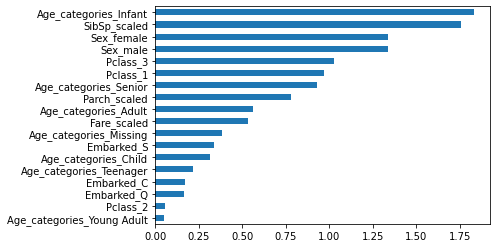

In [6]:
lr = LogisticRegression()
lr.fit(train[columns], train['Survived'])
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0],index = train[columns].columns)
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

In [7]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']
all_X = train[columns]
all_y = train['Survived']
lr= LogisticRegression() 
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
print(accuracy)

0.8148064918851435


We see that current accuracy is for 81% - slightly better than in my first attempt(without using LogisticRegression.coef_)
To improve this result I will try <b>feature engineering</b> on Fare and Age columns 

In [8]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df


def process_fare(df,cut_points,label_names):
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

In [9]:
cut_points = [0,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]

train = process_fare(train,cut_points,label_names)
holdout = process_fare(holdout,cut_points,label_names)

train = create_dummies(train,"Fare_categories")
holdout = create_dummies(holdout,"Fare_categories")

In [10]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)
extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

holdout["Cabin_type"] = holdout["Cabin"].str[0]
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

for column in ["Title","Cabin_type"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

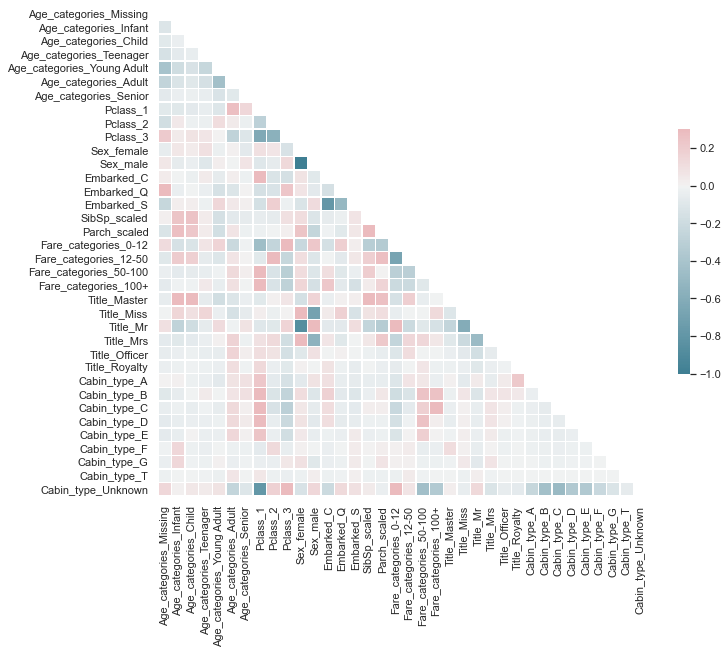

In [11]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']


plot_correlation_heatmap(train[columns])

In [16]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]

lr = LogisticRegression() 
selector = RFECV(lr, cv=10)
selector.fit(all_X, all_y)
optimized_columns = all_X.columns[selector.support_]

In [17]:
print(optimized_columns)

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')


In [18]:
print(len(columns))

29


I will train model by using only those columns which returned after RFECV

In [19]:
all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression() 
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()

In [20]:
print(accuracy)

0.8226591760299625


#### There is slight improvement vs my first attempt :) lastly I received 80%, now it is 82% 

#### Let's check how it will work on holdout(test) data 

In [21]:
lr = LogisticRegression() 
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[optimized_columns])

holdout_ids = holdout['PassengerId']
submission_df = {'PassengerId':holdout_ids,
                'Survived':holdout_predictions}

submission = pd.DataFrame(submission_df)
submission.to_csv("submission_2.csv", index=False)

It occured that it helped me to receive result = 0.77511 (in fris)